In [206]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd
from pipeline_scripts.utils import (
    get_experiment_pads,
    get_and_create_folders,
    add_dir_to_experiment_filemap,
    create_temp_folders,
    backup_file,
    get_experiment_time_from_filemap_parallel,
    merge_and_save_csv,
    rename_merge_and_save_csv,
)
import numpy as np
import argparse
from pipeline_scripts.building_blocks import build_config_of_building_blocks
import matplotlib.pyplot as plt

from towbintools.data_analysis import compute_growth_rate_per_larval_stage, correct_series_with_classification, filter_series_with_classification, compute_larval_stage_duration

from scipy import interpolate
import seaborn as sns

In [207]:
def compute_series_at_time_classified(
    series: np.ndarray,
    worm_types: np.ndarray,
    time: float,
    fit_width: int = 10,
) -> float:
    """
    Compute the value of a time series at a given time using linear regression on a logarithmic transformation of the data.

    This function uses linear regression on a logarithmic transformation of the volume data to predict
    the volume at the specified hatch time and end-molts. Only data points where `worm_types` is "worm"
    are used for fitting. The function returns the volume at desired time.

    Parameters:
        volume (np.ndarray): A time series representing volume.
        worm_types (np.ndarray): An array indicating the type of each entry in the volume time series. Expected values are "worm", "egg", etc.
        time (float): The time at which the volume is to be computed.
        fit_width (int, optional): Width for the linear regression fit used in computing the volume. Default is 10.

    Returns:
        float: Volume at desired time.
    """

    if np.isfinite(time):
        fit_x = np.arange(
            max(0, int(time - fit_width)),
            min(len(series), int(time + fit_width)),
            dtype=int,
        )

        filtered_fit_x = fit_x[np.where(worm_types[fit_x] == "worm")]
        if filtered_fit_x.size != 0:
            fit_y = np.log(series[filtered_fit_x])
            try:
                p = np.polyfit(filtered_fit_x, fit_y, 1)
            except Exception as e:
                print(
                    f"Caught an exception while interpolating volume at time {time}, returning nan : {e}"
                )
                return np.nan
            series_at_time = np.exp(np.polyval(p, time))
        else:
            series_at_time = np.nan
    else:
        series_at_time = np.nan

    return float(series_at_time)

def compute_series_at_ecdysis_classified(
    series: np.ndarray,
    worm_types: np.ndarray,
    ecdysis: np.ndarray,
    fit_width: int = 10,
) -> np.ndarray:
    """
    Compute the value of a time series at the time of ecdysis using linear regression on a logarithmic transformation of the data.

    This function uses linear regression on a logarithmic transformation of the volume data to predict
    the volume at the specified hatch time and end-molts. Only data points where `worm_types` is "worm"
    are used for fitting. The function returns the volume at desired time.

    Parameters:
        volume (np.ndarray): A time series representing volume.
        worm_types (np.ndarray): An array indicating the type of each entry in the volume time series. Expected values are "worm", "egg", etc.
        ecdysis (np.ndarray): An array indicating the time of ecdysis.
        fit_width (int, optional): Width for the linear regression fit used in computing the volume. Default is 10.

    Returns:
        np.ndarray: Volume at desired time.
    """

    series_at_ecdysis = np.zeros_like(ecdysis, dtype=float)

    for i, time in enumerate(ecdysis):
        series_at_ecdysis[i] = compute_series_at_time_classified(
            series, worm_types, time, fit_width
        )

    return series_at_ecdysis

In [208]:
filemap_path = "/mnt/towbin.data/shared/kstojanovski/20240625_Orca_10x_yap-1aid-raga-1aid_wBT186-437-438-439_25C_20240625_154359_670/analysis/report/analysis_filemap_annotated.csv"
experiment_filemap = pd.read_csv(filemap_path)
experiment_filemap.head()

,Time,Point,raw,ExperimentTime,analysis/ch2_seg,analysis/ch1_seg,analysis/ch1_ch2_raw_str,analysis/ch1_seg_str,analysis/ch2_seg_str,ch1_seg_str_volume,...,ch2_seg_str_area_at_M1,ch2_seg_str_area_at_M2,ch2_seg_str_area_at_M3,ch2_seg_str_area_at_M4,VolumeAtM1,VolumeAtM3,VolumeAtM2,VolumeAtHatch,VolumeAtM4,None
0,0,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,0.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1848.247358,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
1,1,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,599.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1720.558896,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
2,2,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1199.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1600.419582,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
3,3,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1800.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1706.539048,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
4,4,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,2400.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1036.174619,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN


In [209]:
config_path = './config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    file.close()

def build_conditions(config):
    conditions = []
    condition_id = 0

    for condition in config["conditions"]:
        condition = {key: [val] if not isinstance(val, list) else val for key, val in condition.items()}

        lengths = set(len(val) for val in condition.values())
        if len(lengths) > 2 or (len(lengths) == 2 and 1 not in lengths):
            raise ValueError("All lists in the condition must have the same length or be of length 1.")

        max_length = max(lengths)
        for i in range(max_length):
            condition_dict = {
                key: val[0] if len(val) == 1 else val[i]
                for key, val in condition.items()
            }
            condition_dict["condition_id"] = condition_id
            conditions.append(condition_dict)
            condition_id += 1

    return conditions
    
conditions = build_conditions(config)
conditions

[{'auxin_concentration_um': 0,
  'strain': 'wBT186',
  'point_range': [0, 26],
  'condition_id': 0},
 {'auxin_concentration_um': 0,
  'strain': 'wBT437',
  'point_range': [27, 54],
  'condition_id': 1},
 {'auxin_concentration_um': 0,
  'strain': 'wBT438',
  'point_range': [55, 86],
  'condition_id': 2},
 {'auxin_concentration_um': 0,
  'strain': 'wBT439',
  'point_range': [87, 120],
  'condition_id': 3},
 {'auxin_concentration_um': 10,
  'strain': 'wBT186',
  'point_range': [121, 147],
  'condition_id': 4},
 {'auxin_concentration_um': 10,
  'strain': 'wBT437',
  'point_range': [148, 176],
  'condition_id': 5},
 {'auxin_concentration_um': 10,
  'strain': 'wBT438',
  'point_range': [177, 204],
  'condition_id': 6},
 {'auxin_concentration_um': 10,
  'strain': 'wBT439',
  'point_range': [205, 232],
  'condition_id': 7},
 {'auxin_concentration_um': 50,
  'strain': 'wBT186',
  'point_range': [233, 250],
  'condition_id': 8},
 {'auxin_concentration_um': 50,
  'strain': 'wBT437',
  'point_rang

In [210]:
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [211]:
def add_conditions_to_filemap(experiment_filemap, conditions, config):
    for condition in conditions:
        if "point_range" in condition.keys():
            point_range = condition["point_range"]
            # Get all the rows that are in the point range
            condition_rows = experiment_filemap[experiment_filemap["Point"].between(point_range[0], point_range[1])]
            # Remove the point range from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "point_range"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val
    return experiment_filemap

experiment_filemap = add_conditions_to_filemap(experiment_filemap, conditions, config)
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [212]:
experiment_filemap["condition_id"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [213]:
conditions_struct = []

def get_ecdysis_and_durations(filemap):
    all_ecdysis_time_step = []
    all_durations_time_step = []

    all_ecdysis_experiment_time = []
    all_durations_experiment_time = []
    
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        point_ecdysis = point_df[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0]
        larval_stage_durations = list(compute_larval_stage_duration(point_ecdysis).values())

        point_ecdysis = point_ecdysis.to_numpy()
        all_ecdysis_time_step.append(point_ecdysis)
        all_durations_time_step.append(larval_stage_durations)

        ecdysis_experiment_time = []
        for ecdys in point_ecdysis:
            if np.isnan(ecdys):
                ecdysis_experiment_time.append(np.nan)
            else:
                ecdys_experiment_time = point_df[point_df["Time"] == ecdys]["ExperimentTime"].iloc[0]
                ecdysis_experiment_time.append(ecdys_experiment_time)

        all_ecdysis_experiment_time.append(ecdysis_experiment_time)
        
        durations_experiment_time = []
        for i in range(len(ecdysis_experiment_time) - 1):
            start = ecdysis_experiment_time[i]
            end = ecdysis_experiment_time[i + 1]
            duration_experiment_time = end - start
            durations_experiment_time.append(duration_experiment_time)

        all_durations_experiment_time.append(durations_experiment_time)
        
    return np.array(all_ecdysis_time_step), np.array(all_durations_time_step), np.array(all_ecdysis_experiment_time), np.array(all_durations_experiment_time)

def separate_column_by_point(filemap, column):
    separated_column = []
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        separated_column.append(point_df[column].values)
    return np.array(separated_column)
        
# body_channel = 2
# pharynx_channel = 1

organ_channels = {'body' : 2, 'pharynx' : 1}

# body_channel = f'ch{body_channel}'
# pharynx_channel = f'ch{pharynx_channel}'
        
for condition_id in experiment_filemap["condition_id"].unique():
    condition_df = experiment_filemap[experiment_filemap["condition_id"] == condition_id]
    condition_dict = {}

    ecdysis_time_step, larval_stage_durations_time_step, ecdysis_experiment_time, larval_stage_durations_experiment_time = get_ecdysis_and_durations(condition_df)
    condition_dict['ecdysis_time_step'] = ecdysis_time_step
    condition_dict['larval_stage_durations_time_step'] = larval_stage_durations_time_step
    condition_dict['ecdysis_experiment_time'] = ecdysis_experiment_time
    condition_dict['larval_stage_durations_experiment_time'] = larval_stage_durations_experiment_time

    worm_type_column = [col for col in condition_df.columns if 'worm_type' in col][0]
    worm_types = separate_column_by_point(condition_df, worm_type_column)

    for organ in organ_channels.keys():
        organ_channel = organ_channels[organ]
        organ_channel = f'ch{organ_channel}'
        organ_columns = [col for col in condition_df.columns if col.startswith(organ_channel)]
        organ_columns = [col for col in organ_columns if not ('_at_' in col)]
        renamed_organ_columns = [col.replace(organ_channel, organ) for col in organ_columns]

        for organ_column, renamed_organ_column in zip(organ_columns, renamed_organ_columns):
            condition_dict[renamed_organ_column] = separate_column_by_point(condition_df, organ_column)

        # remove any column with worm_type in it
        renamed_organ_columns = [col for col in renamed_organ_columns if not ('worm_type' in col)]
        for column in renamed_organ_columns:
            condition_dict[f'{column}_at_ecdysis'] = np.stack([compute_series_at_ecdysis_classified(condition_dict[column][i], worm_types[i], ecdysis_time_step[i]) for i in range(len(ecdysis_time_step))])


    condition_dict['time'] = separate_column_by_point(condition_df, 'Time').astype(float)
    condition_dict['experiment_time'] = separate_column_by_point(condition_df, 'ExperimentTime').astype(float)

    # for column in renamed_organ_columns:
    #     condition_dict[f'{column}_at_ecdysis'] = np.array([compute_series_at_ecdysis_classified(condition_dict[column][i], worm_types[i], ecdysis_time_step[i]) for i in range(len(ecdysis_time_step))])


    conditions_struct.append(condition_dict)
        # organ_size_columns = [col for col in organ_columns if col.endswith("volume") or col.endswith("area") or col.endswith("length")] 
        # organ_length_column = [col for col in organ_columns if col.endswith("length")][0]
        # organ_area_column = [col for col in organ_columns if col.endswith("area")][0]
        # organ_volume_column = [col for col in organ_columns if col.endswith("volume")][0]

        # condition_dict[f'{organ}_length_column'] = organ_length_column
        # condition_dict[f'{organ}_area_column'] = organ_area_column
        # condition_dict[f'{organ}_volume_column'] = organ_volume_column
    # condition_dict['condition_id'] = condition_id

    # # process body columns
    # body_columns = [col for col in condition_df.columns if col.startswith(body_channel)]
    # body_size_columns = [col for col in body_columns if col.endswith("volume") or col.endswith("area") or col.endswith("length")] 
    # body_length_column = [col for col in body_columns if col.endswith("length")][0]
    # body_area_column = [col for col in body_columns if col.endswith("area")][0]
    # body_volume_column = [col for col in body_columns if col.endswith("volume")][0]
    # print(condition_dict)


Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
Caught an exception while interpolating volume at time 184.0, returning nan : SVD did not converge in Linear Least Squares
Caught an exception while interpolating volume at time 86.0, returning nan : SVD did not converge in Linear Least Squares

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

Intel MK

In [214]:
def interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points = 100):
    if larval_stage < 1 or larval_stage > 4:
        raise ValueError("The larval stage must be between 1 and 4.")
    
    previous_ecdys = ecdysis[larval_stage-1]
    ecdys = ecdysis[larval_stage]

    # check that the molts are correct
    if (np.isnan(previous_ecdys) or np.isnan(ecdys)) or previous_ecdys > ecdys:
        return np.full(n_points, np.nan), np.full(n_points, np.nan)
    
    # convert ecdysis times to int to get the index
    previous_ecdys = int(previous_ecdys)
    ecdys = int(ecdys)

    interpolated_time = np.linspace(time[previous_ecdys], time[ecdys], n_points)
    interpolated_series = interpolate.interp1d(time, series, kind='linear')(interpolated_time)

    return interpolated_time, interpolated_series

def interpolate_entire_development(time, series, ecdysis, n_points = 100):
    interpolated_time = np.full((4, n_points), np.nan)
    interpolated_series = np.full((4, n_points), np.nan)
    for larval_stage in range(1, 5):
        interpolated_time_stage, interpolated_series_stage = interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points)
        
        interpolated_time[larval_stage - 1, :] = interpolated_time_stage
        interpolated_series[larval_stage - 1, :] = interpolated_series_stage

    return interpolated_time, interpolated_series

def interpolate_entire_development_classified(time, series, ecdysis, worm_type, n_points = 100):
    time = filter_series_with_classification(time, worm_type)
    series = filter_series_with_classification(series, worm_type)
    
    return interpolate_entire_development(time, series, ecdysis, n_points)

In [215]:
def rescale_and_aggregate(series, time, ecdysis, larval_stage_durations, worm_type, points=None, aggregation='mean', n_points=100):

    if points is not None:
        series = series[points]
        time = time[points]
        worm_type = worm_type[points]
        ecdysis = ecdysis[points]
        larval_stage_durations = larval_stage_durations[points]
    
    if aggregation == 'mean':
        aggregation_function = np.nanmean
    elif aggregation == 'median':
        aggregation_function = np.nanmedian
    else:
        raise ValueError(f"The aggregation method must be either 'mean' or 'median', not {aggregation}.")
    
    # Interpolate the time and the series

    all_points_interpolated_time = []
    all_points_interpolated_series = []

    for point in range(series.shape[0]):
        series_point, time_point, ecdysis_point, worm_type_point = series[point], time[point], ecdysis[point], worm_type[point]
        interpolated_time, interpolated_series = interpolate_entire_development_classified(time_point, series_point, ecdysis_point, worm_type_point, n_points = n_points)

        all_points_interpolated_time.append(interpolated_time)
        all_points_interpolated_series.append(interpolated_series)

    all_points_interpolated_time = np.array(all_points_interpolated_time)
    all_points_interpolated_series = np.array(all_points_interpolated_series)

    aggregated_series = np.full((4, n_points), np.nan)
    std_series = np.full((4, n_points), np.nan)
    ste_series = np.full((4, n_points), np.nan)
    rescaled_time = np.full((4, n_points), np.nan)

    aggregated_larval_stage_durations = aggregation_function(larval_stage_durations, axis=0)

    for i in range(4):
        aggregated_series[i, :] = aggregation_function(all_points_interpolated_series[:, i, :], axis=0)
        std_series[i, :] = np.nanstd(all_points_interpolated_series[:, i, :], axis=0)
        ste_series[i, :] = np.nanstd(all_points_interpolated_series[:, i, :], axis=0) / np.sqrt(np.sum(np.isfinite(all_points_interpolated_series[:, i, :])))

        beginning = np.nansum(aggregated_larval_stage_durations[:i+1]) - aggregated_larval_stage_durations[i]
        end = np.nansum(aggregated_larval_stage_durations[:i+1])
        rescaled_time[i, :] = np.linspace(beginning, end, n_points)

    # flatten the arrays
    aggregated_series = aggregated_series.flatten()
    std_series = std_series.flatten()
    ste_series = ste_series.flatten()
    rescaled_time = rescaled_time.flatten()

    return rescaled_time, aggregated_series, std_series, ste_series

/tmp/ipykernel_1870423/802209427.py:37: RuntimeWarning: Mean of empty slice
  aggregated_larval_stage_durations = aggregation_function(larval_stage_durations, axis=0)
/tmp/ipykernel_1870423/802209427.py:40: RuntimeWarning: Mean of empty slice
  aggregated_series[i, :] = aggregation_function(all_points_interpolated_series[:, i, :], axis=0)
/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


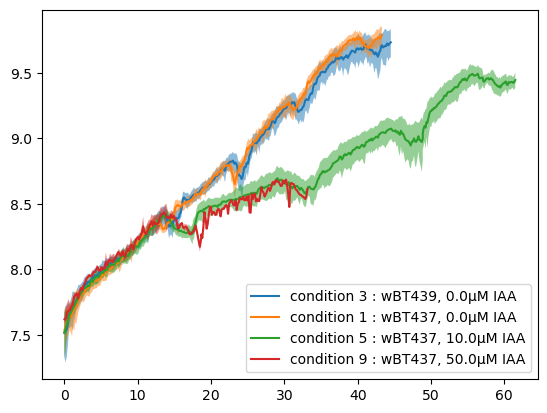

In [216]:
for cond in [3, 1, 5, 9]:
    df_condition = experiment_filemap[experiment_filemap['condition_id'] == cond]
    condition_dict = conditions_struct[cond]
    rescaled_time, aggregated_series, std_series, ste_series = rescale_and_aggregate(condition_dict['pharynx_seg_str_volume'], condition_dict['experiment_time'], condition_dict['ecdysis_time_step'], condition_dict['larval_stage_durations_experiment_time'], condition_dict['body_seg_str_worm_type'], aggregation='mean', n_points=100)

    plt.plot(rescaled_time/3600, np.log(aggregated_series), label=f'condition {cond} : {df_condition["strain"].iloc[0]}, {df_condition["auxin_concentration_um"].iloc[0]}µM IAA')
    plt.fill_between(rescaled_time/3600, np.log(aggregated_series - std_series), np.log(aggregated_series + std_series), alpha=0.5)

plt.legend()
plt.show()

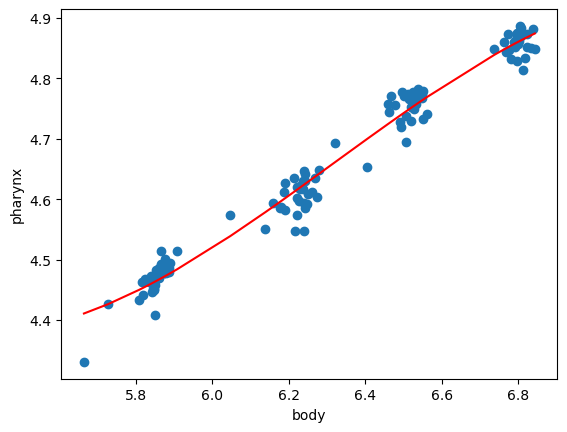

In [217]:
def get_proportion_model(series_one_at_ecdysis, series_two_at_ecdysis, remove_hatch = True):
    assert len(series_one_at_ecdysis) == len(series_two_at_ecdysis), "The two series must have the same length."

    if remove_hatch:
        series_one_at_ecdysis = series_one_at_ecdysis[:, 1:]
        series_two_at_ecdysis = series_two_at_ecdysis[:, 1:]
    series_one_at_ecdysis = np.array(series_one_at_ecdysis).flatten()
    series_two_at_ecdysis = np.array(series_two_at_ecdysis).flatten()

    # remove elements that are nan in one of the two arrays
    correct_indices = ~np.isnan(series_one_at_ecdysis) & ~np.isnan(series_two_at_ecdysis)
    series_one_at_ecdysis = series_one_at_ecdysis[correct_indices]
    series_two_at_ecdysis = series_two_at_ecdysis[correct_indices]

    # log transform the data
    series_one_at_ecdysis = np.log(series_one_at_ecdysis)
    series_two_at_ecdysis = np.log(series_two_at_ecdysis)

    plt.scatter(series_one_at_ecdysis, series_two_at_ecdysis)
    plt.xlabel('body')
    plt.ylabel('pharynx')

    fit = np.polyfit(series_one_at_ecdysis, series_two_at_ecdysis, 3)
    model = np.poly1d(fit)

    plt.plot(np.sort(series_one_at_ecdysis), model(np.sort(series_one_at_ecdysis)), color='red')
    plt.show()

    return model

condition_dict = conditions_struct[3]
model = get_proportion_model(condition_dict['body_seg_str_length_at_ecdysis'], condition_dict['pharynx_seg_str_length_at_ecdysis'])

/tmp/ipykernel_1870423/4079237098.py:26: RuntimeWarning: Mean of empty slice
  y = np.nanmean(residuals, axis=0)
/tmp/ipykernel_1870423/4079237098.py:28: RuntimeWarning: Mean of empty slice
  x = np.nanmean(body_data, axis=0)


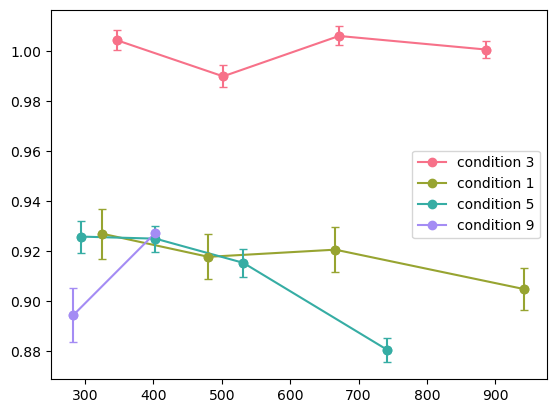

In [218]:
color_palette = sns.color_palette("husl", 4)
# for i, condition in enumerate([0, 4, 8]):
for i, condition in enumerate([3, 1, 5, 9]):
# for i, condition in enumerate([3, 2, 6, 10]):
# for i, condition in enumerate(list(range(12))):
    condition_dict = conditions_struct[condition]
    body_data, pharynx_data = condition_dict['body_seg_str_length_at_ecdysis'], condition_dict['pharynx_seg_str_length_at_ecdysis']

    body_data = body_data[:, 1:]
    pharynx_data = pharynx_data[:, 1:]

    # remove elements that are nan in one of the two arrays
    correct_indices = ~np.isnan(body_data) & ~np.isnan(pharynx_data)
    pharynx_data[~correct_indices] = np.nan
    body_data[~correct_indices] = np.nan

    # log transform the data
    body_data = np.log(body_data)
    pharynx_data = np.log(pharynx_data)

    expected_pharynx = model(body_data)

    log_residuals = pharynx_data - expected_pharynx
    residuals = np.exp(log_residuals)

    y = np.nanmean(residuals, axis=0)
    y_err = np.nanstd(residuals, axis=0)/np.sqrt(len(residuals))
    x = np.nanmean(body_data, axis=0)
    
    plt.plot(np.exp(x), y, color=color_palette[i], marker='o', label=f'condition {condition}')
    plt.errorbar(np.exp(x), y, yerr=y_err, color=color_palette[i], fmt='o', capsize=3)
plt.legend()
plt.show()

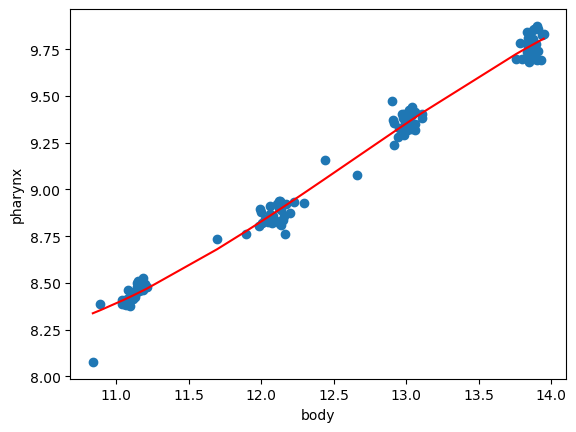

In [219]:
condition_dict = conditions_struct[3]
model = get_proportion_model(condition_dict['body_seg_str_volume_at_ecdysis'], condition_dict['pharynx_seg_str_volume_at_ecdysis'])

/tmp/ipykernel_1870423/2993130409.py:26: RuntimeWarning: Mean of empty slice
  y = np.nanmean(residuals, axis=0)
/tmp/ipykernel_1870423/2993130409.py:28: RuntimeWarning: Mean of empty slice
  x = np.nanmean(body_data, axis=0)


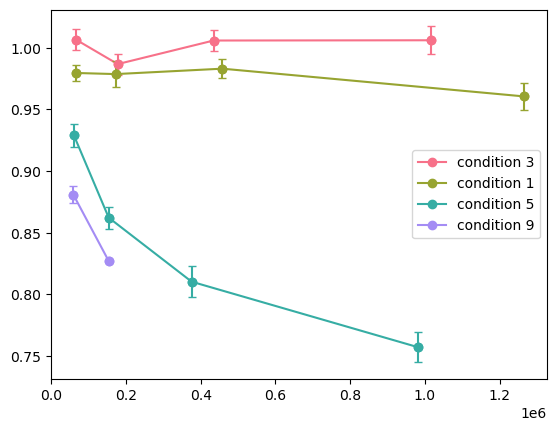

In [220]:
color_palette = sns.color_palette("husl", 4)
# for i, condition in enumerate([0, 4, 8]):
for i, condition in enumerate([3, 1, 5, 9]):
# for i, condition in enumerate([3, 2, 6, 10]):
# for i, condition in enumerate(list(range(12))):
    condition_dict = conditions_struct[condition]
    body_data, pharynx_data = condition_dict['body_seg_str_volume_at_ecdysis'], condition_dict['pharynx_seg_str_volume_at_ecdysis']

    body_data = body_data[:, 1:]
    pharynx_data = pharynx_data[:, 1:]

    # remove elements that are nan in one of the two arrays
    correct_indices = ~np.isnan(body_data) & ~np.isnan(pharynx_data)
    pharynx_data[~correct_indices] = np.nan
    body_data[~correct_indices] = np.nan

    # log transform the data
    body_data = np.log(body_data)
    pharynx_data = np.log(pharynx_data)

    expected_pharynx = model(body_data)

    log_residuals = pharynx_data - expected_pharynx
    residuals = np.exp(log_residuals)

    y = np.nanmean(residuals, axis=0)
    y_err = np.nanstd(residuals, axis=0)/np.sqrt(len(residuals))
    x = np.nanmean(body_data, axis=0)
    
    plt.plot(np.exp(x), y, color=color_palette[i], marker='o', label=f'condition {condition}')
    plt.errorbar(np.exp(x), y, yerr=y_err, color=color_palette[i], fmt='o', capsize=3)
plt.legend()
plt.show()

/tmp/ipykernel_1870423/2921867511.py:18: RuntimeWarning: Mean of empty slice
  y = aggregation_function(normalized_pharynx_to_body_ratio, axis=0)
/tmp/ipykernel_1870423/2921867511.py:20: RuntimeWarning: Mean of empty slice
  x = np.nanmean(body_data, axis=0)


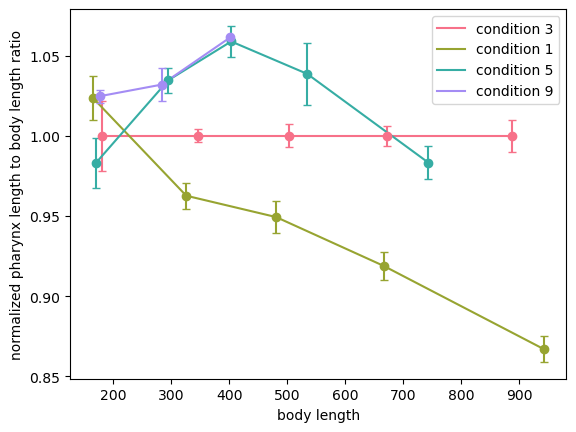

In [221]:
control_condition = 3
control_condition_dict = conditions_struct[control_condition]
body_data, pharynx_data = control_condition_dict['body_seg_str_length_at_ecdysis'], control_condition_dict['pharynx_seg_str_length_at_ecdysis']

pharynx_to_body_ratio = pharynx_data / body_data

aggregation_function = np.nanmean
control_pharynx_to_body_ratio = aggregation_function(pharynx_to_body_ratio, axis=0)

for i, condition in enumerate([3, 1, 5, 9]):
    condition_dict = conditions_struct[condition]
    body_data, pharynx_data = condition_dict['body_seg_str_length_at_ecdysis'], condition_dict['pharynx_seg_str_length_at_ecdysis']

    pharynx_to_body_ratio = pharynx_data / body_data

    normalized_pharynx_to_body_ratio = pharynx_to_body_ratio / control_pharynx_to_body_ratio

    y = aggregation_function(normalized_pharynx_to_body_ratio, axis=0)
    y_err = np.nanstd(normalized_pharynx_to_body_ratio, axis=0)/np.sqrt(len(normalized_pharynx_to_body_ratio))
    x = np.nanmean(body_data, axis=0)

    plt.plot(x, y, label=f'condition {condition}', color=color_palette[i])
    plt.errorbar(x, y, yerr=y_err, fmt='o', capsize=3, color=color_palette[i])
plt.legend()
plt.xlabel('body length')
plt.ylabel('normalized pharynx length to body length ratio') 
plt.show()

/tmp/ipykernel_1870423/3437612879.py:18: RuntimeWarning: Mean of empty slice
  y = aggregation_function(normalized_pharynx_to_body_ratio, axis=0)
/tmp/ipykernel_1870423/3437612879.py:20: RuntimeWarning: Mean of empty slice
  x = aggregation_function(body_data, axis=0)


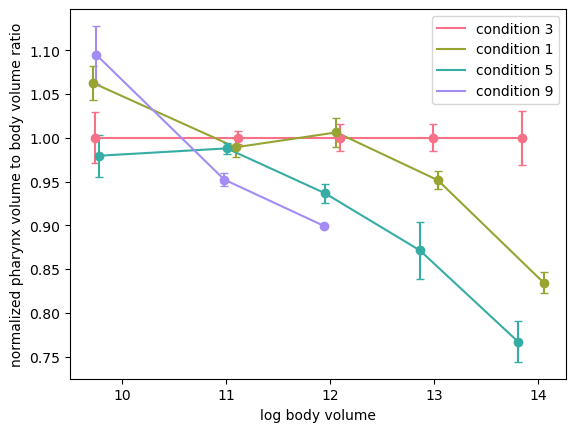

In [222]:
control_condition = 3
control_condition_dict = conditions_struct[control_condition]
body_data, pharynx_data = control_condition_dict['body_seg_str_volume_at_ecdysis'], control_condition_dict['pharynx_seg_str_volume_at_ecdysis']

pharynx_to_body_ratio = pharynx_data / body_data

aggregation_function = np.nanmean
control_pharynx_to_body_ratio = aggregation_function(pharynx_to_body_ratio, axis=0)

for i, condition in enumerate([3, 1, 5, 9]):
    condition_dict = conditions_struct[condition]
    body_data, pharynx_data = condition_dict['body_seg_str_volume_at_ecdysis'], condition_dict['pharynx_seg_str_volume_at_ecdysis']

    pharynx_to_body_ratio = pharynx_data / body_data

    normalized_pharynx_to_body_ratio = pharynx_to_body_ratio / control_pharynx_to_body_ratio

    y = aggregation_function(normalized_pharynx_to_body_ratio, axis=0)
    y_err = np.nanstd(normalized_pharynx_to_body_ratio, axis=0)/np.sqrt(len(normalized_pharynx_to_body_ratio))
    x = aggregation_function(body_data, axis=0)

    plt.plot(np.log(x), y, label=f'condition {condition}', color=color_palette[i])
    plt.errorbar(np.log(x), y, yerr=y_err, fmt='o', capsize=3, color=color_palette[i])
plt.legend()
plt.xlabel('log body volume')
plt.ylabel('normalized pharynx volume to body volume ratio')
plt.show()